In [1]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: sympy in c:\users\xvard\anaconda3\lib\site-packages (from torch) (1.6.2)

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3


In [2]:
#Importing all Libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import copy
from tqdm import tqdm

In [3]:
file = Image.open("D:\ml\RESEARCH PUBLICATION\MATERIALS AND METHODS\IMAGES\\frame0.jpg")

In [4]:
img = np.array(file)
img.shape

(600, 800, 3)

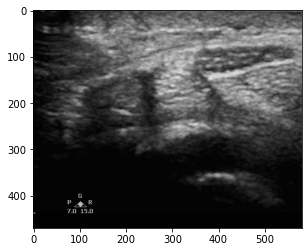

In [5]:
plt.imshow(img[80:550,120:700,:])

# Dataloader

In [6]:
#Importing pytorch
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform

        # Assuming that the images and labels have the same base name
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
        self.label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.tif')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        label_name = os.path.join(self.labels_dir, self.label_files[idx])

        # Open image and label
        image = Image.open(img_name).convert("RGB")
        label = Image.open(label_name)

        image = np.array(image)[80:550,120:700,:]
        label = np.array(label)[80:550,120:700]

        image = Image.fromarray(image)
        label = Image.fromarray(label)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        # Convert label to a tensor
        

        return image, label

# Define any transformations you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create the dataset
images_dir = 'D:\ml\RESEARCH PUBLICATION\MATERIALS AND METHODS\IMAGES'  # Replace with your image directory
labels_dir = 'D:\ml\RESEARCH PUBLICATION\MATERIALS AND METHODS\LABELS'  # Replace with your label directory
dataset = CustomImageDataset(images_dir=images_dir, labels_dir=labels_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


# Example usage: iterate through the data
for images, labels in train_loader:
    print(images, labels)
    break


tensor([[[[0.0157, 0.0157, 0.0157,  ..., 0.6667, 0.6706, 0.6706],
          [0.0157, 0.0157, 0.0157,  ..., 0.3961, 0.4157, 0.4392],
          [0.0157, 0.0157, 0.0157,  ..., 0.2275, 0.2431, 0.2627],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]],

         [[0.0157, 0.0157, 0.0157,  ..., 0.6667, 0.6706, 0.6706],
          [0.0157, 0.0157, 0.0157,  ..., 0.3961, 0.4157, 0.4392],
          [0.0157, 0.0157, 0.0157,  ..., 0.2275, 0.2431, 0.2627],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]],

         [[0.0157, 0.0157, 0.0157,  ..., 0.6667, 0.6706, 0.6706],
          [0.0157, 0.0157, 0.0157,  ..., 0.3961, 0.4157, 0.4392],
          [0.0157, 0.0157, 0.0157,  ..., 0

# Model Architecture

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:  # If mid_channels is not specified, it defaults to the value of out_channels.
            mid_channels = out_channels
            # A sequential container that holds the series of operations: 
        # Conv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU
        self.double_conv = nn.Sequential(  
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))
        # self.decision = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        # final = self.decision(logits)
        return logits


# Training and Validation

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(n_channels=3, n_classes=1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Replace with your preferred loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Replace with your preferred optimizer

def calculate_iou(preds, labels, threshold=0.5):
    preds = (preds > threshold).float()
    
    # Use logical operations instead of bitwise operations
    intersection = torch.logical_and(preds, labels).float().sum((1, 2))
    union = torch.logical_or(preds, labels).float().sum((1, 2))
    
    iou = (intersection + 1e-6) / (union + 1e-6)  # To avoid division by zero
    return iou.mean()

# Set the model to the appropriate device

num_epochs = 25
best_model_wts = copy.deepcopy(model.state_dict())
best_iou = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    # Training loop
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_iou = 0.0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + optimize
        loss.backward()
        optimizer.step()

        # Calculate IoU
        preds = torch.sigmoid(outputs)
        iou = calculate_iou(preds, labels)

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_iou += iou.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_iou = running_iou / len(train_loader.dataset)

    print(f'Train Loss: {epoch_loss:.4f} IoU: {epoch_iou:.4f}')

    # Validation loop
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    running_iou = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate IoU
            preds = torch.sigmoid(outputs)
            iou = calculate_iou(preds, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_iou += iou.item() * inputs.size(0)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_iou = running_iou / len(val_loader.dataset)

    print(f'Validation Loss: {epoch_loss:.4f} IoU: {epoch_iou:.4f}')

    # Save the model if it has the best IoU so far
    if epoch_iou > best_iou:
        best_iou = epoch_iou
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

# Load the best model weights after training
model.load_state_dict(best_model_wts)
print('Training complete. Best Validation IoU: {:4f}'.format(best_iou))


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch 1/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.3744 IoU: 0.6249


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.8723 IoU: 0.1741

Epoch 2/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.1889 IoU: 0.9393


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.2195 IoU: 0.6239

Epoch 3/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.1284 IoU: 0.9465


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.1099 IoU: 0.9277

Epoch 4/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0910 IoU: 0.9448


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0831 IoU: 0.9539

Epoch 5/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0674 IoU: 0.9465


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0635 IoU: 0.9188

Epoch 6/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0519 IoU: 0.9469


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0518 IoU: 0.9392

Epoch 7/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0425 IoU: 0.9439


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0392 IoU: 0.9546

Epoch 8/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0344 IoU: 0.9479


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0351 IoU: 0.9581

Epoch 9/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0294 IoU: 0.9498


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0273 IoU: 0.9334

Epoch 10/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0260 IoU: 0.9473


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0224 IoU: 0.9362

Epoch 11/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0244 IoU: 0.9419


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0364 IoU: 0.9345

Epoch 12/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0226 IoU: 0.9411


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0189 IoU: 0.9515

Epoch 13/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0200 IoU: 0.9428


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0178 IoU: 0.9558

Epoch 14/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0175 IoU: 0.9488


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0194 IoU: 0.9203

Epoch 15/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0166 IoU: 0.9475


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0199 IoU: 0.9487

Epoch 16/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0155 IoU: 0.9486


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0163 IoU: 0.9362

Epoch 17/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0159 IoU: 0.9437


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0164 IoU: 0.9568

Epoch 18/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0145 IoU: 0.9458


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0192 IoU: 0.9431

Epoch 19/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0138 IoU: 0.9476


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0120 IoU: 0.9521

Epoch 20/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0134 IoU: 0.9470


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0142 IoU: 0.9179

Epoch 21/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0149 IoU: 0.9413


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0174 IoU: 0.9566

Epoch 22/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0121 IoU: 0.9491


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0166 IoU: 0.9487

Epoch 23/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0118 IoU: 0.9491


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0116 IoU: 0.9530

Epoch 24/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0115 IoU: 0.9494


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.0113 IoU: 0.9405

Epoch 25/25
----------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.0113 IoU: 0.9477


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.98s/it]

Validation Loss: 0.0146 IoU: 0.9521

Training complete. Best Validation IoU: 0.958135


In [11]:
model.eval()

# Initialize variables to store the IoU and count of samples
total_iou = 0.0
total_samples = 0

# Disable gradient computation
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Apply a threshold to get the predicted masks (for binary segmentation)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        # Calculate IoU for the batch
        iou = calculate_iou(preds, labels)

        # Accumulate IoU and sample count
        total_iou += iou.item() * inputs.size(0)
        total_samples += inputs.size(0)

# Calculate the average IoU over all test samples
average_iou = total_iou / total_samples

print(f"Testing complete. Average IoU: {average_iou:.4f}")


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.22s/it]

Testing complete. Average IoU: 0.9588


# Save Trained Model

In [12]:
PATH = os.path.abspath("D:\\ml\\RESEARCH PUBLICATION\\MATERIALS AND METHODS\\unet.pth")
torch.save(model.state_dict(),PATH)

# Restore Saved Model

In [13]:
restore_path = "D:\\ml\\RESEARCH PUBLICATION\\MATERIALS AND METHODS\\unet.pth"
model.load_state_dict(torch.load(restore_path))

<ipython-input-13-77f7689dcac4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(restore_path))


<All keys matched successfully>

# Visualize Results

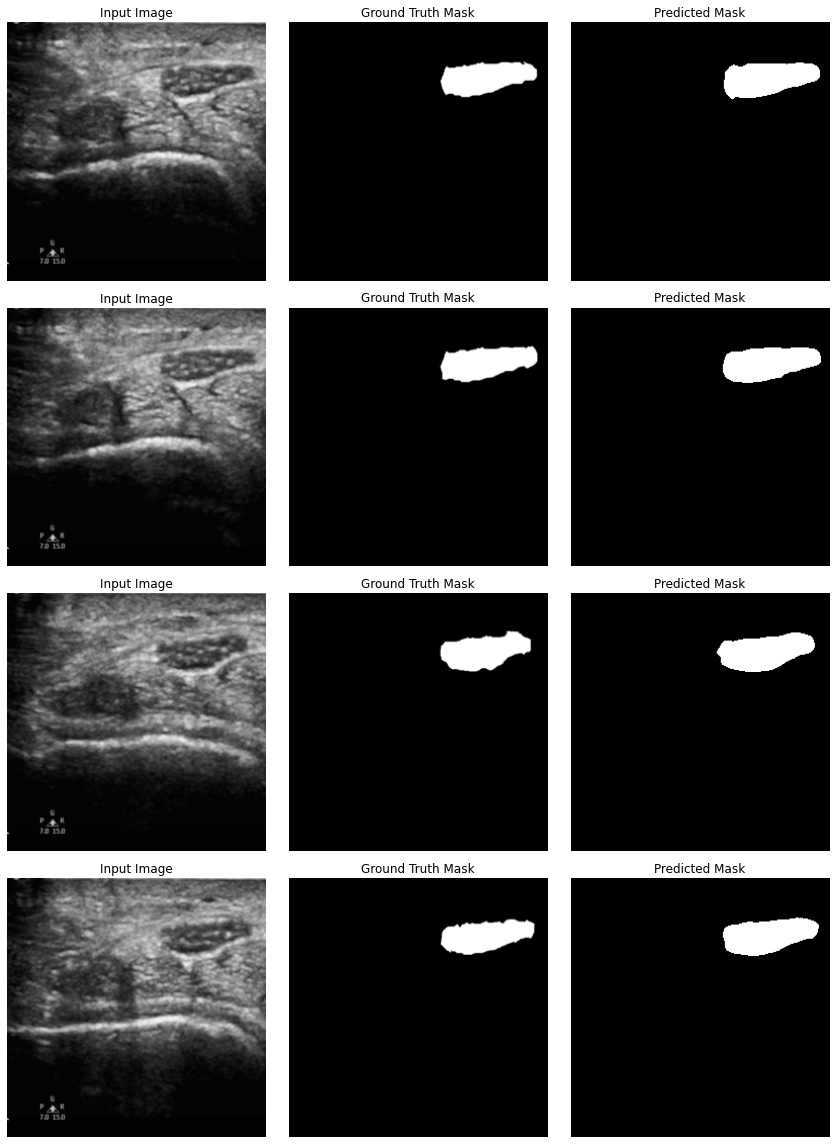

In [14]:
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Get the model predictions
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()

# Move tensors to CPU for visualization
inputs = inputs.cpu()
labels = labels.cpu()
preds = preds.cpu()

# Define the number of examples to visualize
num_examples = min(inputs.size(0), 4)  # Max 4 examples

# Create a 4x3 grid for visualization
fig, axes = plt.subplots(num_examples, 3, figsize=(12, num_examples * 4))

for i in range(num_examples):
    # Input Image
    axes[i, 0].imshow(inputs[i].permute(1, 2, 0))  # Change from CHW to HWC for visualization
    axes[i, 0].set_title('Input Image')
    axes[i, 0].axis('off')

    # Ground Truth Mask
    axes[i, 1].imshow(labels[i].squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    axes[i, 1].set_title('Ground Truth Mask')
    axes[i, 1].axis('off')

    # Predicted Mask
    axes[i, 2].imshow(preds[i].squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Metrics

In [15]:
def calculate_segmentation_metrics(predicted_mask, ground_truth_mask):
 
    predicted_mask_cpu = predicted_mask.cpu().numpy()
    predicted_mask = (predicted_mask_cpu >= 0.5).astype(np.uint8)
    ground_truth_mask = ground_truth_mask.unsqueeze(1).cpu().numpy()
 
    # intersection = np.sum(predicted_mask_cpu*ground_truth_mask)
    # union = np.sum(predicted_mask_cpu + ground_truth_mask - (predicted_mask_cpu*ground_truth_mask))
    # dice = 2 * intersection/(union+intersection)
 
    # Compute TP, FP, FN, and TN
    TP = np.sum((predicted_mask == 1) & (ground_truth_mask == 1))
    FP = np.sum((predicted_mask == 1) & (ground_truth_mask == 0))
    FN = np.sum((predicted_mask == 0) & (ground_truth_mask == 1))
    TN = np.sum((predicted_mask == 0) & (ground_truth_mask == 0))
 
    # Calculate precision, recall, and IoU
    if TP + FP == 0:
        precision = 0.0
    else:
        precision = TP / (TP + FP)
    if TP + FN == 0:
        recall = 0.0
    else:
        recall = TP / (TP + FN)
    dice = 2*TP/(2*TP + FN + FP)
 
    return precision, recall, dice
 
 
results = {"Precision":[], "Recall":[],  "Dicescore":[]}
presc = []
rec = []
dsc =[]
hausd = []
with torch.no_grad():
    model.eval()
    for dat in tqdm(test_loader):
        image_file,mask_file=dat
 
        image_file=image_file
        mask_file=mask_file
        #print(i,'image_file_shape:',image_file.shape,'mask_file_shape:',mask_file.shape)
 
        image_file=image_file.float()   
        mask_file=mask_file.float()
 
        image_file=image_file.to(device)
        mask_file=mask_file.to(device)
 
        output = model(image_file)
        precision, recall, dice= calculate_segmentation_metrics(output, mask_file)
 
        dsc.append(dice)
        presc.append(precision)
        rec.append(recall)
 
    results["Dicescore"].append(sum(dsc)/len(dsc))
    results["Precision"].append(sum(presc)/len(presc))
    results["Recall"].append(sum(rec)/len(rec))
 
print(results)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.40s/it]

{'Precision': [0.9267349244536204], 'Recall': [0.9616631771132647], 'Dicescore': [0.9438756725061891]}
